<a href="https://colab.research.google.com/github/xy2119/Brain_MRI_Image_Segmentation/blob/main/notebooks/Covid19_NER_BioBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Natural Language Processing | Named Entity Recognition with BioBERT
# Submission to the 2021 Imperial College Data Science Challenge

In the 2021 **[Data Science Institute](https://www.imperial.ac.uk/data-science/) Natural Language Processing Challenge**, a dataset was made available for text mining task, which is the [CORD-19](https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge) dataset from Kaggle. We're keen on looking into word representations and relational graphs that could serve as a medical and scientific knowledge repository.

This notebook extracts biomedical entities from the Covid19 literatures (title, abstract, body...) by fine-tuning BioBERT.

### **What is a Biomedical Entity?**
Biomedical entity is a term that refers to anything related to the field of biomedicine. This can include things like proteins, genes, diseases, and medical treatments etc.

### **Why Named Entity Recognition in the Biomedical Field**
Named entity recognition (NER) is an important task used to extract information from biomedical articles.
NER is the process to automatically recognize and classify the named entities. After extraction, they can be used in downstream tasks such as relation extraction, knowledge base construction, and knowledge discovery. 

### **BioBERT**
BioBERT is model that is pre-trained on the biomedical datasets. In the pre-training, weights of the regular BERT model was taken and then pre-trained on the medical datasets like (PubMed abstracts and PMC). This domain-specific pre-trained model can be fine-tunned on smaller task-specific datasets. Literatures has proven that fine-tuning BIOBERT model outperformed the fine-tuned BERT model for the biomedical domain-specific NLP tasks.


Some information might be helpful before repreducing this notebook:


* I track my training using `wandb`. `wandb` is a tool for tracking and visualising machine learning experiments in real time on [Weights & Biases](https://wandb.ai/site) platform. Create an account and experiment with the interactive dashboards! If you already have an account, that's fantastic! To monitor this experiment, launch the notebook and paste your API key from your profile.


* I import CORD 19 NER Dataset from Google Drive, the dataset URL is available [here](https://drive.google.com/drive/folders/1Y4MUrrfT-Xuos83nOnq8ZWTMZmp9qADH?usp=sharing). Credit to Sushil Kumar [(profile)](https://www.linkedin.com/in/sushilksharma1/) for processing the dataset.


Feel free to contact me at xy2119@ic.ac.uk

# Install and Import Libraries

In [ ]:
!pip install wandb
!pip install tqdm
!python -m spacy download en
!pip install transformers
!pip install pytorch-pretrained-bert

In [1]:
import os
import re
import csv
import warnings
import itertools
import nltk
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import functools
import itertools
import operator
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import sklearn.metrics as metrics

import spacy
from spacy import displacy
nlp = spacy.blank('en')

import gc
import torch
import torch.nn as nn
import pytorch_pretrained_bert
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers import BertForTokenClassification, AdamW
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from seqeval.metrics import classification_report as classification_report_seqeval


import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
torch.cuda.empty_cache()
gc.collect()

98

In [3]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [4]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('GPU type:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
GPU type: A100-SXM4-40GB


In [6]:
# wandb login
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xy2119 (fancykid). Use `wandb login --relogin` to force relogin


True

In [7]:
# Initialize W&B    
wandb.init(project="covid19_knowledge_representation")

# Download Pretrained BioBERT

In [ ]:
!git clone https://huggingface.co/dmis-lab/biobert-v1.1

In [ ]:
!unzip -o /content/drive/MyDrive/COVID19_KG/ner_covid19_data.csv.zip -d ./

# Load CORD 19 NER Dataset
Fullset of data is 63308700 in length. A subset is sampled here for this notebook

In [8]:
df=pd.read_csv('/content/ner_covid19_data.csv')
len(df)

63308700

In [10]:
data=df[:50000]
data.fillna('0',inplace=True)
data.drop(columns=["Unnamed: 0"],inplace=True)
drop_tags_less_than_10000=list(data['1'].value_counts()[data['1'].value_counts() < 10000].index)

index__to_drop=[]
for i in drop_tags_less_than_10000:
    index__to_drop.extend(data[ data['1'] == i ].index)
    
data.drop(index__to_drop, inplace = True)

data.rename(columns={"0": "Word", "1": "Tag","2":"Sentence #"},inplace=True)
data.drop(data.query('Tag == "Other"').sample(frac=.9).index, inplace = True)

tag_values = data['Tag'].values
vocab_len = len(tag_values)
print('No. of entities:',vocab_len)

No. of entities: 3827


In [11]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]
getter = GetSentence(data)

In [12]:
tag1 = [[word[1] for word in sentence] for sentence in getter.sentence]
sentences1 = [[word[0] for word in sentence] for sentence in getter.sentence]

sentences = sentences1
tags = tag1

In [13]:
MAX_LEN = 100
BATCH_SIZE = 16
tokenizer = BertTokenizer(vocab_file='/content/biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

def tok_with_labels(sent, text_labels):
    tok_sent = []
    labels = []
    for word, label in zip(sent, text_labels):
        tok_word = tokenizer.tokenize(word)
        n_subwords = len(tok_word)

        tok_sent.extend(tok_word)
        labels.extend([label] * n_subwords)
    return tok_sent, labels

%time
tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [14]:
for char in tok_texts:
    print('Example of tokenized wordpiece:\n', char)
    break

Example of tokenized wordpiece:
 ['mechanisms', 'analysis', '[', '3', ',', 'possible', 'there', 'many', 'have', 'strong', 'studies', 'share']


In [15]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [16]:
tag_values = list(set(itertools.chain.from_iterable(tags)))
tag_values.append("PAD")

tag2idx = {t: i for i,t in enumerate(tag_values)}
print('No. of tag indices:', tag2idx)

No. of tag indices: {'Other': 0, 'PAD': 1}


In [17]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [18]:
# save you ids and tags in case the full dataset run out of you RAM and crashed
# pd.DataFrame(input_ids).to_csv(r'input_ids.txt', header=None, index=None, sep=' ', mode='a')
# pd.DataFrame(tags).to_csv(r'tags.txt', header=None, index=None, sep=' ', mode='a')

In [19]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [20]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2022, test_size=0.18)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2022, test_size=0.18)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [21]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [22]:
config = BertConfig.from_json_file('/content/biobert_v1.1_pubmed/config.json')
tmp_d = torch.load('/content/biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [23]:
class BioBertNER(nn.Module):
    def __init__(self, vocab_len, config, state_dict):
        super().__init__()
        self.bert = BertModel(config)
        self.bert.load_state_dict(state_dict, strict=False)
        self.dropout = nn.Dropout(p=0.10)
        self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encl = encoded_layer[-1]
        out = self.dropout(encl)
        out = self.output(out)
        return out, out.argmax(-1)

# Model Architecture With Pretrained Weights


In [24]:
model = BioBertNER(vocab_len,config,state_dict)
model.to(device)

BioBertNER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
        

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)
epochs = 20
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [31]:
wandb.config.update = {
  "learning_rate": 5e-5,
  "epochs": 20,
  "batch_size": 16,
  "eps": 1e-8,
  "max_grad_norm": 1.0
}

# Model Training and Evaluation (tracked by wandb.)

In [26]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    for step,batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(device).long() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs,y_hat = model(b_input_ids,b_input_mask)
        
        _,preds = torch.max(outputs,dim=2)
        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)
        loss = loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [27]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device).long() for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)
            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
        
    
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [28]:
%%time
history = defaultdict(list)
best_accuracy = 0
normalizer = BATCH_SIZE*MAX_LEN
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    train_acc = train_acc/normalizer
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)  
    loss_values.append(avg_train_loss)
    
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    val_acc = val_acc/normalizer
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    wandb.log({"train_acc":train_acc, "train_loss":train_loss,"val_acc":val_acc,"val_loss":val_loss,})

======== Epoch 1/20 ========


21it [00:02,  8.20it/s]


Train Loss: 2.325054889633542 Train Accuracy: 0.8092857142857143
Val Loss: 0.5990190267562866 Val Accuracy: 0.809
======== Epoch 2/20 ========


21it [00:01, 11.34it/s]


Train Loss: 0.5147379033622288 Train Accuracy: 0.8751488095238095
Val Loss: 0.07912601679563522 Val Accuracy: 0.9125
======== Epoch 3/20 ========


21it [00:01, 11.20it/s]


Train Loss: 0.05251270293125084 Train Accuracy: 0.9761904761904763
Val Loss: 0.012264871038496494 Val Accuracy: 0.9125
======== Epoch 4/20 ========


21it [00:01, 11.31it/s]


Train Loss: 0.01719637569927034 Train Accuracy: 0.9761904761904763
Val Loss: 0.00786614753305912 Val Accuracy: 0.9125
======== Epoch 5/20 ========


21it [00:01, 11.31it/s]


Train Loss: 0.017481766641139984 Train Accuracy: 0.9748809523809523
Val Loss: 0.006592871248722076 Val Accuracy: 0.9125
======== Epoch 6/20 ========


21it [00:01, 11.33it/s]


Train Loss: 0.010358952030184724 Train Accuracy: 0.9761904761904763
Val Loss: 0.005189283471554518 Val Accuracy: 0.9125
======== Epoch 7/20 ========


21it [00:01, 11.26it/s]


Train Loss: 0.008507519649962584 Train Accuracy: 0.9761607142857142
Val Loss: 0.004521099757403136 Val Accuracy: 0.9125
======== Epoch 8/20 ========


21it [00:01, 11.13it/s]


Train Loss: 0.007604492251716909 Train Accuracy: 0.9761904761904763
Val Loss: 0.003950533457100391 Val Accuracy: 0.9125
======== Epoch 9/20 ========


21it [00:01, 11.32it/s]


Train Loss: 0.006524642020286549 Train Accuracy: 0.9761904761904763
Val Loss: 0.003494596667587757 Val Accuracy: 0.9125
======== Epoch 10/20 ========


21it [00:01, 11.34it/s]


Train Loss: 0.005872780479313363 Train Accuracy: 0.9761904761904763
Val Loss: 0.0031978955492377283 Val Accuracy: 0.9125
======== Epoch 11/20 ========


21it [00:01, 11.34it/s]


Train Loss: 0.0053687684371003085 Train Accuracy: 0.9761904761904763
Val Loss: 0.0029352221637964247 Val Accuracy: 0.9125
======== Epoch 12/20 ========


21it [00:01, 11.22it/s]


Train Loss: 0.0049535226342933515 Train Accuracy: 0.9761904761904763
Val Loss: 0.0027305235620588065 Val Accuracy: 0.9125
======== Epoch 13/20 ========


21it [00:01, 11.27it/s]


Train Loss: 0.004639158069732643 Train Accuracy: 0.9761904761904763
Val Loss: 0.0025704404804855587 Val Accuracy: 0.9125
======== Epoch 14/20 ========


21it [00:01, 11.31it/s]


Train Loss: 0.004396003449246997 Train Accuracy: 0.9761904761904763
Val Loss: 0.002443480212241411 Val Accuracy: 0.9125
======== Epoch 15/20 ========


21it [00:01, 11.26it/s]


Train Loss: 0.004189393394404934 Train Accuracy: 0.9761904761904763
Val Loss: 0.002335597760975361 Val Accuracy: 0.9125
======== Epoch 16/20 ========


21it [00:01, 11.28it/s]


Train Loss: 0.004012308826315261 Train Accuracy: 0.9761904761904763
Val Loss: 0.0022550362162292005 Val Accuracy: 0.9125
======== Epoch 17/20 ========


21it [00:01, 11.34it/s]


Train Loss: 0.003898823722487404 Train Accuracy: 0.9761904761904763
Val Loss: 0.0021939555648714305 Val Accuracy: 0.9125
======== Epoch 18/20 ========


21it [00:01, 11.24it/s]


Train Loss: 0.0038106578757010753 Train Accuracy: 0.9761904761904763
Val Loss: 0.002150867972522974 Val Accuracy: 0.9125
======== Epoch 19/20 ========


21it [00:01, 11.34it/s]


Train Loss: 0.003743567836603948 Train Accuracy: 0.9761904761904763
Val Loss: 0.0021253110375255347 Val Accuracy: 0.9125
======== Epoch 20/20 ========


21it [00:01, 11.32it/s]


Train Loss: 0.0037006320365305457 Train Accuracy: 0.9761904761904763
Val Loss: 0.0021161667071282865 Val Accuracy: 0.9125
CPU times: user 38.8 s, sys: 2.02 s, total: 40.8 s
Wall time: 40.5 s


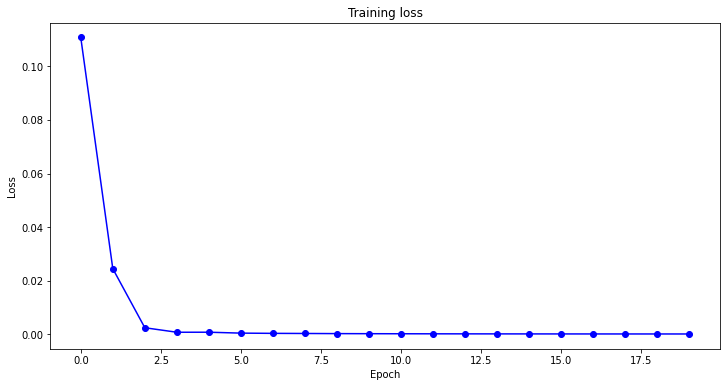

In [30]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Testing

In [50]:
text = """IPakistan has vaccinated over 122 million people. The two vaccines in widespread use are inactivated (BBIBP-CorV & Sinovac) and mRNA forms (BNT162b2 & mRNA-1273). The primary aim of this study was to compare these two forms of vaccines against unvaccinated individuals collectively and then to see which one is more efficacious. Case–control study design was used to compare the efficacy of inactivated and mRNA vaccines against symptomatic infection, hospitalisations and mortality due to Severe Acute Respiratory Syndrome Coronavirus 2 between vaccinated and unvaccinated individuals. We derived recovery time from illness for both vaccines. Furthermore, we also compared the vaccines against similar parameters (symptomatic disease, hospitalisations and mortality). We calculated crude odds ratios for each dependent variable. p value of 0.05 or below was considered significant.
"""
text = re.sub(r"(@\[A-Za-z0-9]+)|([^.0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

print(text)

IPakistan has vaccinated over 122million people. The two vaccines in widespread use are inactivated BBIBPCorV  Sinovac and mRNA forms BNT162b2  mRNA1273. The primary aim of this study was to compare these two forms of vaccines against unvaccinated individuals collectively and then to see which one is more efficacious. Casecontrol study design was used to compare the efficacy of inactivated and mRNA vaccines against symptomatic infection hospitalisations and mortality due to Severe Acute Respiratory Syndrome Coronavirus 2 between vaccinated and unvaccinated individuals. We derived recovery time from illness for both vaccines. Furthermore we also compared the vaccines against similar parameters symptomatic disease hospitalisations and mortality. We calculated crude odds ratios for each dependent variable. p value of 0.05 or below was considered significant.


In [51]:
sent_text1=[]
for i in sent_text:
    sent_text1.append(re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i))

tokenized_text = []
for sentence in sent_text1:
    tokenized_text.append(nltk.word_tokenize(sentence))

In [52]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word)   
        tokenized_sentence.extend(tokenized_word)
    return tokenized_sentence

tok_texts = [tokenize_and_preserve(sent) for sent in tokenized_text]
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
input_attentions = [[1]*len(in_id) for in_id in input_ids]
tokens = tokenizer.convert_ids_to_tokens(input_ids[1])
new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_tokens.append(token)

In [53]:
actual_sentences = []
pred_labels = []
for x,y in zip(input_ids,input_attentions):
    x = torch.tensor(x).cuda()
    y = torch.tensor(y).cuda()
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

In [54]:
sent=[]
tags=[]

for token, label in zip(actual_sentences, pred_labels):
    for t,l in zip(token,label):
        sent.append(t)
        tags.append(l)

In [55]:
lst=[]
total_words=[]
temp=0
test_sentence=' '.join(sent)
for key,i in enumerate(sent):
    if i not in total_words:
        re_string = r"\b({})\b".format(i)
        start=re.search(re_string, test_sentence).start()
        end=re.search(re_string, test_sentence).end()
        dict1={}
        dict1["start"]=start+temp
        dict1["end"]=end
        dict1["label"]=tags[key]
        dict1["Word"]=i
        total_words.append(i)

        lst.append(dict1)
        
    else:
        start=start+len(sent[key-1])
        end=end+len(i)+1

        dict1={}
        dict1["start"]=start
        dict1["end"]=end
        dict1["label"]=tags[key]+'2'
        dict1["Word"]=i
        total_words.append(i)

        lst.append(dict1)

In [56]:
ex = [{"text": test_sentence,
       "ents": lst,
       "title": None}]
cols = {'B-CARDINAL': '#dad1f6','B-CHEMICAL': '#f9d5de','B-DISEASE_OR_SYNDROME': '#adcfad','B-GENE_OR_GENOME': '#fbbf9a',\
        'I-CHEMICAL': '#bdf2fa','I-GENE_OR_GENOME': '#eea69e','Other': "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": cols,}

html = displacy.render(ex, style="ent",options=options, manual=True)

In [57]:
model_save = 'BioBERT_NER.pt'
path = F"{model_save}" 
torch.save(model.state_dict(), path)

In [58]:
def report(model,data_loader,device):
    model = model.eval()
    
    all_pred=[]
    true_label=[]
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device).long() for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)
            
            all_pred.extend(preds.tolist())
            true_label.extend(b_labels.tolist())
        
    return all_pred,true_label

def functools_reduce(a):
    return functools.reduce(operator.concat, a)

In [59]:
all_pred,true_label= report(model,valid_dataloader,device)

all_pred=functools_reduce(all_pred)
true_label=functools_reduce(true_label)

In [60]:
idx2tag = {v: k for k, v in tag2idx.items()}
all_pred=[*map(idx2tag.get, all_pred)]
true_label=[*map(idx2tag.get, true_label)]
print(classification_report(true_label, all_pred))

              precision    recall  f1-score   support

       Other       1.00      1.00      1.00       828
         PAD       1.00      1.00      1.00      6472

    accuracy                           1.00      7300
   macro avg       1.00      1.00      1.00      7300
weighted avg       1.00      1.00      1.00      7300

